In [1]:
%matplotlib inline

import glob
import os
import random
import json

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from rubin_sim.utils import getPackageDir
#from rubin_sim.maf import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
from kneMetrics import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
import healpy as hp

Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 0.0}
Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 25.8}
Found matches for 2/2           sets of parameters


/opt/conda/envs/rubin-sims-v0.13.1/lib/python3.10/site-packages/rubin_sim/maf/plots/plotHandler.py:584: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


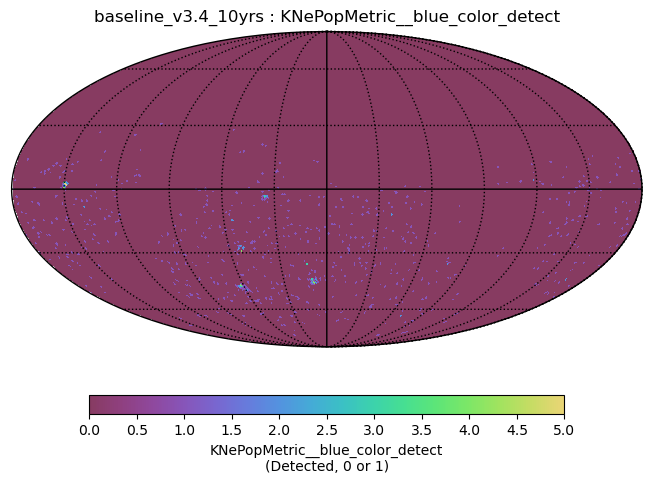

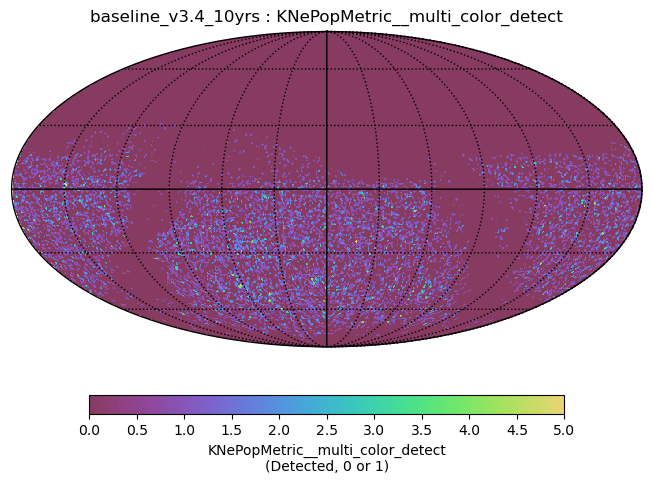

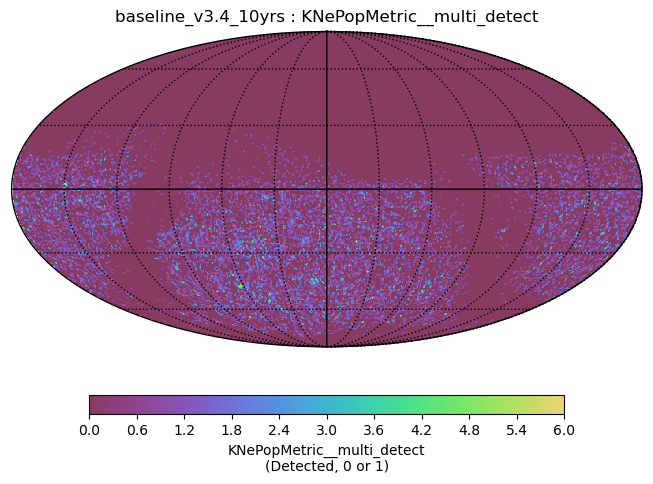

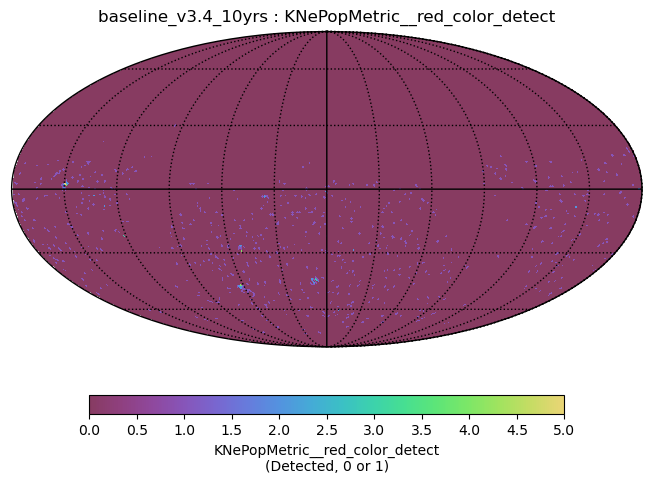

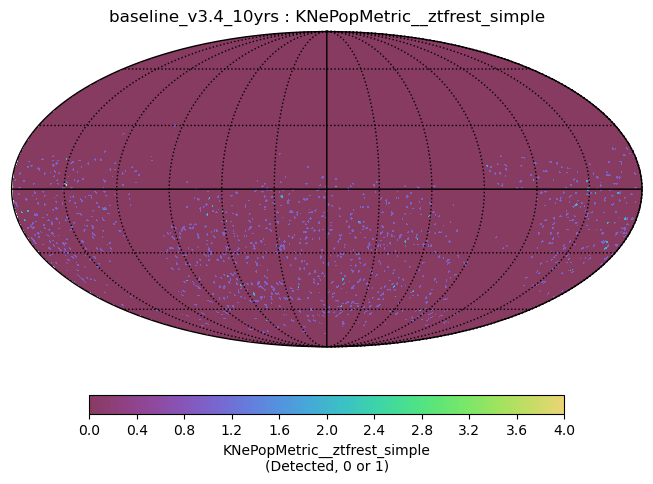

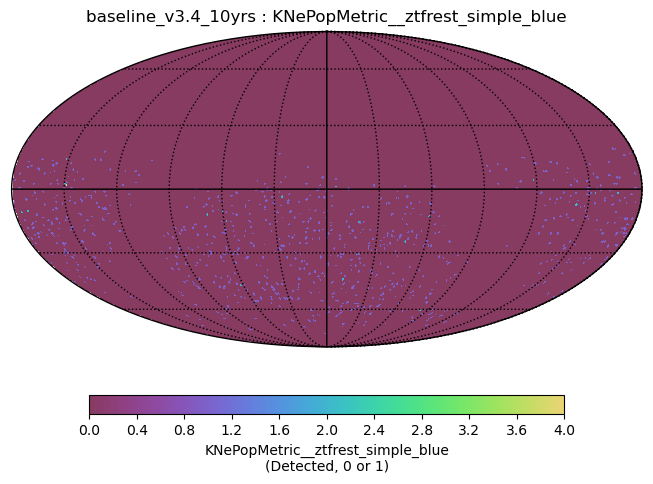

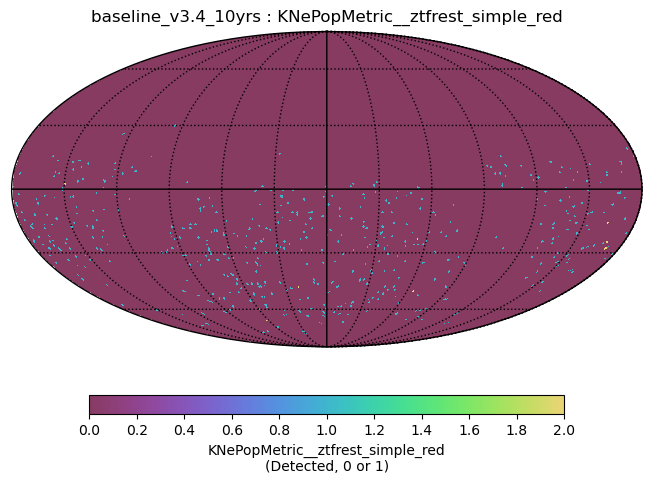

In [2]:
# Minimum and maximum distances for kilonova injection (in Mpc)
dmin = 10
dmax = 1200

# Number of light curves
n_events = 1000000

cadence_nickname = 'baseline_v3.4_10yrs' # only for output filenames

# Output file that collects the efficiency values (transients found/total)
outfile = f"MIL_STRAT/MIL_efficiency_{cadence_nickname}_cadence.csv"

# Kilonova parameters
inj_params_list = [{'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 25.8},
              {'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 0.0}
             ]
filename = get_filename(inj_params_list)

# Start an output file
with open(outfile, "w") as out:
    out.write("dist_min_Mpc, dist_max_Mpc, metric, found, total, efficiency\n")


# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateKNPopSlicer(seed=42, n_events=n_events, n_files=len(filename), d_min=dmin, d_max=dmax)

#runName = 'six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs'
runName = 'baseline_v3.4_10yrs'
#opsdb = db.OpsimDatabase(f'/sims_maf/fbs_1.7.1/new_rolling/{runName}.db')
opsdb = db.OpsimDatabase(f'../shared/rubin_opsims_v3.3_v3.4/baseline/{runName}.db')

outDir = 'MIL_STRAT/MIL_temp'
resultsDb = db.ResultsDb(outDir=outDir)

# Set outputLc=True if you want light curves
metric = KNePopMetric(outputLc=False, file_list=filename)

# Any special request? For example, only one filer?
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
# Plot
bgroup.plotAll(closefigs=False)

# Collect the results in the output file
with open(outfile, "a") as out:
    for key in bd:
        if "USER" in key:
            continue
        found = np.size(np.where(bd[key].metricValues == 1)[0])
        out.write(f"{dmin}, {dmax}, {key}, {found}, {n_events}, {found/n_events}\n")

In [3]:
# Running V1.7 Strategy Release for Kilonovae Metric 